In [133]:
import re
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.optimize import minimize

mu_sol = 1.32712440018e11  # km^3/s^2

In [134]:
def read_parameters(date, filename='cassini_all_orbit.txt'):
    """
    Lê o arquivo de dados e retorna todos os parâmetros para uma data específica

    Args:
        date (str): Data no formato 'ano-Mes-dia'
        filename (str): Nome do arquivo de dados

    Returns:
        dict: Dicionário com todos os parâmetros orbitais
    """

    with open(filename, 'r') as file:
        content = file.read()

    pattern = rf'(\d+\.\d+) = A\.D\. {date}.*?(?=\n\d+\.\d+ = A\.D\.|\Z)'
    match = re.search(pattern, content, re.DOTALL)

    if not match:
        raise ValueError(f"Data {date} não encontrada no arquivo")

    block = match.group(0)

    params = {}

    jd_match = re.search(r'(\d+\.\d+) = A\.D\.', block)
    if jd_match:
        params['JDTDB'] = float(jd_match.group(1))

    param_pattern = r'([A-Za-z]+)\s*=\s*([-+]?\s*\d*\.?\d+(?:[Ee][-+]?\d+)?)'
    matches = re.findall(param_pattern, block)

    for key, value in matches:
        value_clean = re.sub(r'\s+', '', value)
        params[key] = float(value_clean)

    return params


In [135]:
def print_parameters(date, filename='cassini_all_orbit.txt'):
    """
    Lê e imprime todos os parâmetros para uma data específica
    """
    parametros = read_parameters(date, filename)

    print(f"Parâmetros orbitais para {date}:")
    print("=" * 50)

    # Lista de todos os parâmetros na ordem desejada
    parametros_info = [
        ('JDTDB', 'Julian Day Number, Barycentric Dynamical Time'),
        ('EC', 'Eccentricity, e'),
        ('QR', 'Periapsis distance, q (km)'),
        ('IN', 'Inclination w.r.t X-Y plane, i (degrees)'),
        ('OM', 'Longitude of Ascending Node, OMEGA, (degrees)'),
        ('W', 'Argument of Perifocus, w (degrees)'),
        ('Tp', 'Time of periapsis (Julian Day Number)'),
        ('N', 'Mean motion, n (degrees/sec)'),
        ('MA', 'Mean anomaly, M (degrees)'),
        ('TA', 'True anomaly, nu (degrees)'),
        ('A', 'Semi-major axis, a (km)'),
        ('AD', 'Apoapsis distance (km)'),
        ('PR', 'Sidereal orbit period (sec)')
    ]

    for key, description in parametros_info:
        if key in parametros:
            if key == 'JDTDB':
                print(f"{key:4} = {parametros[key]:.6f} # {description}")
            else:
                print(f"{key:4} = {parametros[key]:.15e} # {description}")
        else:
            print(f"{key:4} = NÃO ENCONTRADO # {description}")

In [136]:
def excentricity(r1, theta1, r2, theta2):
    return abs((r2 - r1) / (r1*np.cos(theta1) - r2*np.cos(theta2)))

def semiaxis(r, e, theta):
    return r * (1 + e * np.cos(theta)) / (1 - e**2)

def angular_momentum(r, theta, e, mu):
    p = r * (1 + e * np.cos(theta))
    if p<0:
        p = -p
    h = np.sqrt(mu * p)
    return h
    # return np.sqrt(mu * r * (1 + e * np.cos(theta)))

def tangencial_velocity(mu, h, e, theta):
    return mu / h * (1 + e * np.cos(theta))

def radial_velocity(mu, h, e, theta):
    return mu / h * e * np.sin(theta)

def velocity_magnitude(mu, h, e, theta):
    return mu / h * np.sqrt(e**2 + 2*e*np.cos(theta) + 1)

In [137]:
def eccentric_anomaly_from_true_anomaly(theta, e):
    if 0 <= e < 1:

        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)

        denominator = 1 + e * cos_theta
        sqrt_value = 1 - e**2
        sin_E = np.sqrt(sqrt_value) * sin_theta / denominator
        cos_E = (e + cos_theta) / denominator

        E = np.arctan2(sin_E, cos_E)
        if E < 0:
            E += 2 * np.pi
        return E


    elif e > 1:

        critical_angle = np.arccos(-1/e)
        if abs(theta - critical_angle) < 1e-10 or abs(theta - (2*np.pi - critical_angle)) < 1e-10:
            # Retornar um valor grande mas finito
            return 10.0 if theta > np.pi else -10.0

        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)

        denominator = 1 + e * cos_theta
        if abs(denominator) < 1e-12:
            return 10.0 if theta > np.pi else -10.0

        # Usar a definição de anomalia excêntrica hiperbólica
        H = 2 * np.arctanh(np.sqrt((e - 1) / (e + 1)) * np.tan(theta / 2))
        return H

def mean_anomaly_from_eccentric_anomaly(E, e):
    """Calcula a anomalia média M a partir da anomalia excêntrica E"""
    if e < 1:
        return E - e * np.sin(E)
    else:
        # Para órbitas hiperbólicas
        return e * np.sinh(E) - E

def orbital_period(a, mu):
    return 2 * np.pi * np.sqrt(a**3 / mu)

def time_from_periapsis(theta, e, a, mu):
    """
    Calcula o tempo desde a passagem pelo periastro para uma dada anomalia verdadeira
    Retorna tempo em segundos
    """
    try:
        E = eccentric_anomaly_from_true_anomaly(theta, e)
        M = mean_anomaly_from_eccentric_anomaly(E, e)

        if e < 1:
            n = np.sqrt(mu / abs(a)**3)  # Movimento médio para elípticas
        else:
            # Para órbitas hiperbólicas, usar a definição apropriada
            n = np.sqrt(mu / abs(a)**3)

        return M / n
    except Exception as ex:
        print(f"Erro em time_from_periapsis: {ex}")
        return 0

def calculate_travel_time(theta1, theta2, e, a, mu):
    """
    Calcula o tempo para viajar de theta1 a theta2
    Retorna tempo em dias
    """
    try:
        t1 = time_from_periapsis(theta1, e, a, mu)
        t2 = time_from_periapsis(theta2, e, a, mu)

        # Determinar a direção do movimento
        delta_t = t2 - t1

        # Se delta_t é negativo e é órbita elíptica, a nave passou pelo periastro
        if delta_t < 0 and e < 1:
            T = orbital_period(a, mu)
            delta_t += T

        return delta_t / 86400  # Converter para dias
    except Exception as e:
        print(f"Erro no cálculo do tempo: {e}")
        return 0

In [138]:
def plot_orbit(e, a, theta1, theta2, r1, r2):


    """
    Ta bem ruim o plot

    Plota a órbita elíptica com a parte percorrida em linha contínua

    Args:
        e: excentricidade
        a: semi-eixo maior (km)
        theta1, theta2: anomalias verdadeiras inicial e final (graus)
        r1, r2: raios orbital inicial e final (km)
    """
    # Parâmetros da elipse
    if e < 1:
        b = a * np.sqrt(1 - e**2)  # semi-eixo menor
    elif e > 1:
        b = a * np.sqrt(e**2 - 1)  # semi-eixo menor para hipérbole


    c = e * a  # distância do centro ao foco

    # Gera pontos para a órbita completa
    theta_full = np.linspace(0, 2*np.pi, 1000)
    r_full = a * (1 - e**2) / (1 + e * np.cos(theta_full))

    # Converte para coordenadas cartesianas
    x_full = r_full * np.cos(theta_full)
    y_full = r_full * np.sin(theta_full)

    # Gera pontos para a parte percorrida
    if theta2 > theta1:
        theta_traveled = np.linspace(theta1, theta2, 200)
    else:
        # Se theta2 < theta1, assumimos que passa pelo periastro
        theta_traveled = np.concatenate([
            np.linspace(theta1, 2*np.pi, 100),
            np.linspace(0, theta2, 100)
        ])

    r_traveled = a * (1 - e**2) / (1 + e * np.cos(theta_traveled))
    x_traveled = r_traveled * np.cos(theta_traveled)
    y_traveled = r_traveled * np.sin(theta_traveled)

    # Cria a figura
    plt.figure(figsize=(10, 8))

    # Plot da órbita completa (tracejada)
    plt.plot(x_full, y_full, '--', color='gray', alpha=0.7, label='Órbita completa')

    # Plot da parte percorrida (contínua)
    plt.plot(x_traveled, y_traveled, '-', color='blue', linewidth=2, label='Trajetória percorrida')

    # Marca as posições inicial e final
    plt.plot(r1 * np.cos(theta1), r1 * np.sin(theta1), 'go',
             markersize=8, label=f'Início (θ={theta1:.3f}°)')
    plt.plot(r2 * np.cos(theta2), r2 * np.sin(theta2), 'ro',
             markersize=8, label=f'Fim (θ={theta2:.3f}°)')

    # Marca o Sol no foco
    plt.plot(0, 0, 'yo', markersize=15, label='Sol')
    plt.plot(0, 0, 'y*', markersize=20)

    # Marca o periastro e apoastro
    periastro = a * (1 - e)
    apoastro = a * (1 + e)

    plt.plot([-c, -c], [0, 0], 'kx', markersize=8, label='Centro')
    plt.plot([-c + a, -c - a], [0, 0], 'k--', alpha=0.3)  # Linha do semi-eixo maior

    # Configurações do gráfico
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    # plt.title(f'Órbita Cassini - {data1} a {data2}\n'
            #   f'e = {e:.4f}, a = {a/1e6:.1f}×10⁶ km')
    plt.legend()

    # Adiciona informações textuais

    textstr = f'Δθ = {theta2 - theta1:.1f}°\n' \
              f'r₁ = {r1/1e6:.1f}×10⁶ km\n' \
              f'r₂ = {r2/1e6:.1f}×10⁶ km\n' \
              f'Periastro = {periastro/1e6:.1f}×10⁶ km\n' \
              f'Apoastro = {apoastro/1e6:.1f}×10⁶ km'

    plt.annotate(textstr, xy=(0.02, 0.98), xycoords='axes fraction',
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # Ajusta os limites para melhor visualização
    max_range = max(apoastro, np.max(np.abs(x_full)), np.max(np.abs(y_full)))
    # plt.xlim(-max_range*1.1, max_range*1.1)
    # plt.ylim(-max_range*1.1, max_range*1.1)

    plt.tight_layout()
    # plt.savefig('./Plot_Orbitas/orbita_cassini_' + data1 + '_' + data2 + '.png')
    plt.show()

In [139]:
def dados_da_orbita(start, finish, printa_dados=False, plota_orbita=False):

    data1 = read_parameters(start)
    data2 = read_parameters(finish)

    theta1 = np.radians(data1['TA'])
    theta2 = np.radians(data2['TA'])
    r1 = data1['A'] * (1 - data1['EC']**2) / (1 + data1['EC'] * np.cos(theta1))
    r2 = data2['A'] * (1 - data2['EC']**2) / (1 + data2['EC'] * np.cos(theta2))
    w1 = np.radians(data1['W'])
    w2 = np.radians(data2['W'])
    real_time = (data2['JDTDB'] - data1['JDTDB']) # em dias

    def objetivo(w_orbit):
        # Calcula theta_linha
        theta_linha_1 = theta1 + w1 - w_orbit
        theta_linha_2 = theta2 + w2 - w_orbit

        # Calcula parâmetros orbitais com theta_linha
        e = excentricity(r1, theta_linha_1, r2, theta_linha_2)
        a = semiaxis(r1, e, theta_linha_1)

        # Calcula tempo teórico
        theoretical_time = calculate_travel_time(theta_linha_1, theta_linha_2, e, a, mu_sol)

        # Retorna o erro absoluto (a ser minimizado)
        return abs(theoretical_time - real_time)

    # Otimização - chute inicial: w médio
    w0 = (w1 + w2) / 2.0
    w_min = min(w1, w2)
    w_max = max(w1, w2)
    bounds = [(w_min, w_max)]
    resultado = minimize(objetivo, w0, method='L-BFGS-B', bounds=bounds,
                        options={'maxiter': 1000, 'ftol': 1e-8})

    if resultado.success:
        w_orbit = resultado.x[0]
    else:
        print(f"Otimização falhou para {start}-{finish}. Usando w médio.")
        w_orbit = w0


    theta1 = theta1 + w1 - w_orbit
    theta2 = theta2 + w2 - w_orbit

    e = excentricity(r1, theta1, r2, theta2)
    a = semiaxis(r1, e, theta1)
    h = angular_momentum(r1, theta1, e, mu_sol)
    vr1 = radial_velocity(mu_sol, h, e, theta1)
    vt1 = tangencial_velocity(mu_sol, h, e, theta1)
    v1 = velocity_magnitude(mu_sol, h, e, theta1)
    vr2 = radial_velocity(mu_sol, h, e, theta2)
    vt2 = tangencial_velocity(mu_sol, h, e, theta2)
    v2 = velocity_magnitude(mu_sol, h, e, theta2)

    theoretical_time = calculate_travel_time(theta1, theta2, e, a, mu_sol)
    erro_percentual = abs((theoretical_time - real_time) / real_time) * 100

    if printa_dados:
        print()
        print(f"Parâmetros calculados entre {start} e {finish}:")
        print("=" * 50)
        print(f"w_orbit: {np.degrees(w_orbit):.3f} deg")
        print(f"Excentricidade: {e:.15e}")
        print(f"Semi-eixo maior:{a:.15e} km ")
        print(f"Momento angular: {h:.15e} km^2/s ")
        print(f"Velocidade inicial {start}: vr = {vr1:.15e} km/s, vt = {vt1:.15e} km/s, v_total = {v1:.15e} km/s")
        print(f"Velocidade final {finish}: vr = {vr2:.15e} km/s, vt = {vt2:.15e} km/s, v_total = {v2:.15e} km/s")
        print(f"Tempo real de viagem: {real_time:.6f} dias")
        print(f"Tempo teórico de viagem: {theoretical_time:.6f} dias")
        print(f"Erro percentual: {erro_percentual:.6f} %")
        print("=" * 50)
        print()

    if plota_orbita:
        plot_orbit(e, a, theta1, theta2, r1, r2)

    return {
        'e': e,
        'a': a,
        'h': h,
        'theta_1':theta1,
        'theta_2':theta2,
        'vr_start': vr1,
        'vt_start': vt1,
        'v_start': v1,
        'vr_end': vr2,
        'vt_end': vt2,
        'v_end': v2,
        'real_time_days': real_time,
        'theoretical_time_days': theoretical_time,
        'w_orbit': w_orbit,
        'error_percent': erro_percentual
    }

In [147]:
def trajetoria_completa(orbita1, orbita2, orbita3, orbita4, orbita5, orbita6):
    """
    Plota a trajetória completa usando as órbitas otimizadas
    Inclui órbitas dos planetas como círculos tracejados
    """
    orbitas = [orbita1, orbita2, orbita3, orbita4, orbita5, orbita6]
    nomes_orbitas = ['Órbita 1', 'Órbita 2', 'Órbita 3', 'Órbita 4', 'Órbita 5', 'Órbita 6']
    cores = ['blue', 'green', 'red', 'orange', 'purple', 'brown']

    plt.figure(figsize=(12, 10))

    # Para manter a continuidade angular entre órbitas
    longitude_acumulada = 0

    for i, orbita in enumerate(orbitas):
        if orbita is None or np.isnan(orbita['e']):
            print(f"Órbita {i+1} não disponível para plotagem")
            continue

        e = orbita['e']
        a = orbita['a']
        theta1 = orbita['theta_1']
        theta2 = orbita['theta_2']
        w_orbit = orbita['w_orbit']

        # Longitude para plotagem = theta_linha + w_orbit + longitude_acumulada
        lon1 = theta1 + w_orbit + longitude_acumulada
        lon2 = theta2 + w_orbit + longitude_acumulada

        # Garante continuidade angular
        if i > 0 and abs(lon1 - lon_anterior) > np.pi:
            if lon1 < lon_anterior:
                lon1 += 2 * np.pi
                lon2 += 2 * np.pi

        # Gera pontos para plotagem (do segmento)
        theta_plot = np.linspace(theta1, theta2, 300)
        r_plot = a * (1 - e**2) / (1 + e * np.cos(theta_plot))
        lon_plot = theta_plot + w_orbit + longitude_acumulada

        x_plot = r_plot * np.cos(lon_plot)
        y_plot = r_plot * np.sin(lon_plot)

        # --- Adição: Plotar a elipse completa pontilhada ---
        # 1. Gera ângulos para a elipse completa
        theta_elipse_completa = np.linspace(0, 2 * np.pi, 400)
        # 2. Calcula o raio para cada ângulo
        r_elipse_completa = a * (1 - e**2) / (1 + e * np.cos(theta_elipse_completa))
        # 3. Aplica a rotação da órbita e a longitude acumulada
        lon_elipse_completa = theta_elipse_completa + w_orbit + longitude_acumulada
        # 4. Converte para Cartesiano
        x_elipse_completa = r_elipse_completa * np.cos(lon_elipse_completa)
        y_elipse_completa = r_elipse_completa * np.sin(lon_elipse_completa)

        # 5. Plota a elipse pontilhada (com baixa prioridade visual)
        plt.plot(x_elipse_completa, y_elipse_completa,
                 color=cores[i],
                 linestyle=':',  # Estilo pontilhado
                 linewidth=1,
                 alpha=0.6)
        # --- Fim da Adição ---

        # Plota a trajetória (segmento)
        plt.plot(x_plot, y_plot, color=cores[i], linewidth=2, label=nomes_orbitas[i], alpha=0.8)

        # Marca início e fim
        r1 = a * (1 - e**2) / (1 + e * np.cos(theta1))
        r2 = a * (1 - e**2) / (1 + e * np.cos(theta2))

        plt.plot(r1 * np.cos(lon1), r1 * np.sin(lon1), 'o',
                 color=cores[i], markersize=6, markeredgecolor='black')
        plt.plot(r2 * np.cos(lon2), r2 * np.sin(lon2), 's',
                 color=cores[i], markersize=6, markeredgecolor='black')

        # Atualiza para próxima órbita
        longitude_acumulada = lon2 - orbita['theta_2'] - orbita['w_orbit']
        lon_anterior = lon2


    # Sol no centro
    plt.plot(0, 0, 'yo', markersize=20, label='Sol')
    plt.plot(0, 0, 'y*', markersize=25)
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.title('Trajetória Completa da Cassini')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Informações resumidas
    info_texto = "Resumo das Órbitas da Cassini:\n\n"
    for i, orbita in enumerate(orbitas):
        if orbita is not None and not np.isnan(orbita['e']):
            info_texto += f"{nomes_orbitas[i]}:\n"
            info_texto += f"   w_orbit = {np.degrees(orbita['w_orbit']):.2f}°\n"
            info_texto += f"   e = {orbita['e']:.3f}, a = {orbita['a']/1e6:.1f}×10⁶ km\n"
            info_texto += f"   Erro tempo: {orbita['error_percent']:.1f}%\n\n"

    plt.annotate(info_texto, xy=(0.02, 0.02), xycoords='axes fraction',
                 verticalalignment='bottom',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                 fontsize=8)

    plt.tight_layout()
    plt.savefig('./Plot_Orbitas/trajetoria_completa_cassini.png', dpi=300, bbox_inches='tight')
    plt.figure(figsize=(14, 10))
    plt.show()

In [148]:
def velocity_variation(orbita1, orbita2, orbita3, orbita4, orbita5, orbita6):
    """
    Calcula as variações nas velocidades para cada mudança de orbita
    """
    # Lista de todas as órbitas
    orbitas = [orbita1, orbita2, orbita3, orbita4, orbita5]#, orbita6]
    deltav_r = []
    delatv_t = []
    deltav_total = []

    # pares
    for i in range(len(orbitas)-1):

        vr_final_1 = orbitas[i]['vr_end']
        vt_final_1 = orbitas[i]['vt_end']

        vr_inicial_2 = orbitas[i+1]['vr_start']
        vt_inicial_2 = orbitas[i+1]['vt_start']

        deltav_r.append(vr_inicial_2 - vr_final_1)
        delatv_t.append(vt_inicial_2 - vt_final_1)
        deltav_total.append(math.sqrt((vr_inicial_2 - vr_final_1)**2 + (vt_inicial_2 - vt_final_1)**2))


    return {
        'delta_v_r': np.array(deltav_r),
        'delta_v_t': np.array(delatv_t),
        'delta_v_total': np.array(deltav_total)
        }


In [149]:
orbita1 = dados_da_orbita('1997-Oct-16', '1998-Apr-26', printa_dados=True, plota_orbita=False)
orbita2 = dados_da_orbita('1998-Apr-26', '1998-Dec-03', printa_dados=True, plota_orbita=False)
orbita3 = dados_da_orbita('1998-Dec-03', '1999-Jun-24', printa_dados=True, plota_orbita=False)
orbita4 = dados_da_orbita('1999-Jun-24', '1999-Aug-18', printa_dados=True, plota_orbita=False)
orbita5 = dados_da_orbita('1999-Aug-18', '2000-Dec-30', printa_dados=True, plota_orbita=False)
orbita6 = dados_da_orbita('2000-Dec-30', '2004-Jul-01', printa_dados=True, plota_orbita=False)


Parâmetros calculados entre 1997-Oct-16 e 1998-Apr-26:
w_orbit: 199.275 deg
Excentricidade: 2.053219346804550e-01
Semi-eixo maior:1.255449221834820e+08 km 
Momento angular: 3.994868939195209e+09 km^2/s 
Velocidade inicial 1997-Oct-16: vr = 2.186318526178877e+00 km/s, vt = 2.675966563970638e+01 km/s, v_total = 2.684883039997823e+01 km/s
Velocidade final 1998-Apr-26: vr = 5.799463310602876e+00 km/s, vt = 3.681119709651499e+01 km/s, v_total = 3.726523857926449e+01 km/s
Tempo real de viagem: 192.000000 dias
Tempo teórico de viagem: 192.931241 dias
Erro percentual: 0.485021 %


Parâmetros calculados entre 1998-Apr-26 e 1998-Dec-03:
w_orbit: 199.964 deg
Excentricidade: 4.333915999388556e-01
Semi-eixo maior:1.646948496968641e+08 km 
Momento angular: 4.213274530732323e+09 km^2/s 
Velocidade inicial 1998-Apr-26: vr = 1.151954158381984e+01 km/s, vt = 3.882372151206522e+01 km/s, v_total = 4.049668122633940e+01 km/s
Velocidade final 1998-Dec-03: vr = 4.993576448871471e-01 km/s, vt = 1.78565332374

In [150]:
velocity_variation(orbita1, orbita2, orbita3, orbita4, orbita5, orbita6)

{'delta_v_r': array([ 5.72007827, -0.09845591, -5.05623881, 23.3930532 ]),
 'delta_v_t': array([  2.01252442,   0.53640681,   3.43883212, -12.15847734]),
 'delta_v_total': array([ 6.06379007,  0.54536761,  6.11482766, 26.36405715])}

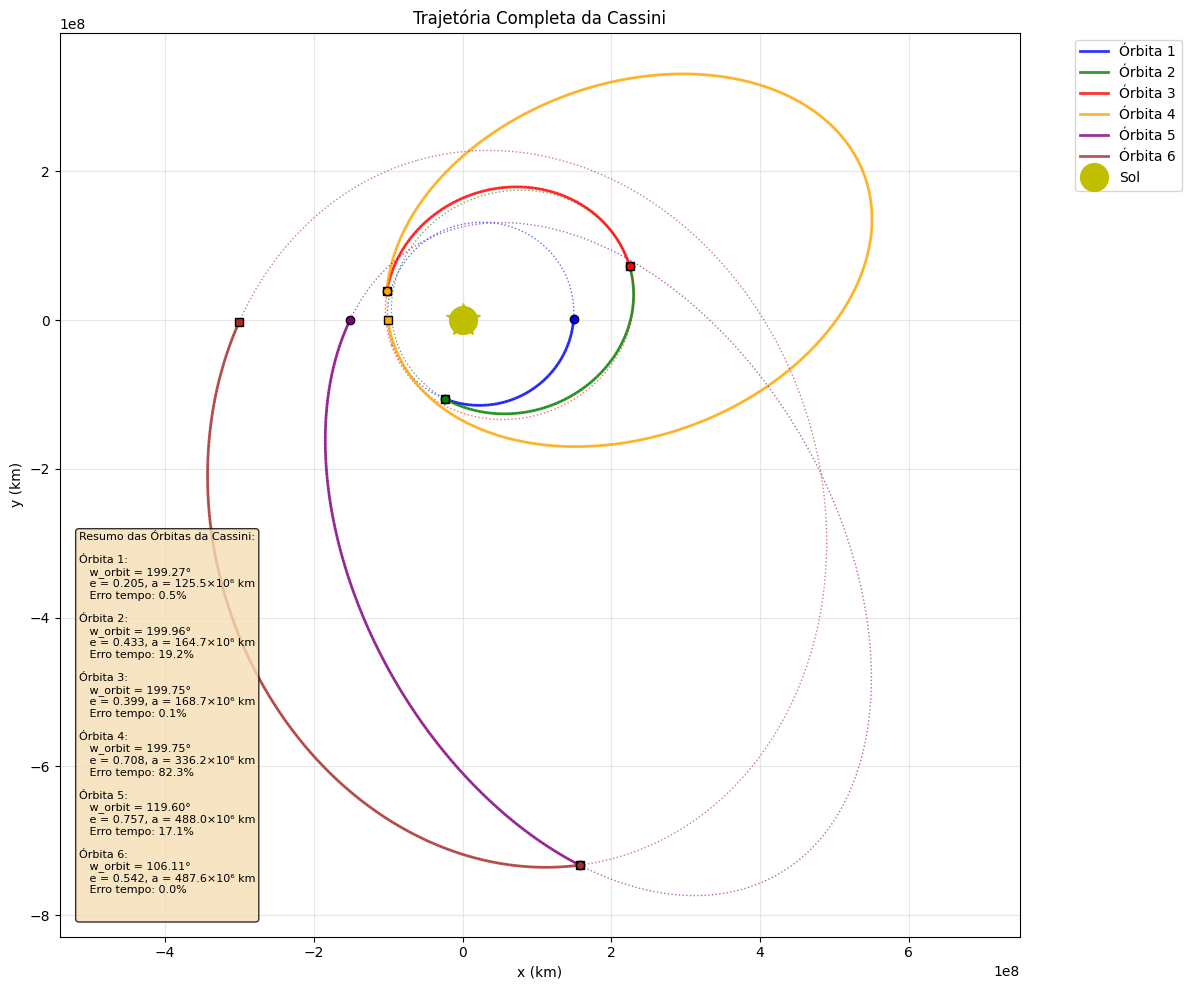

<Figure size 1400x1000 with 0 Axes>

In [151]:
trajetoria_completa(orbita1, orbita2, orbita3, orbita4, orbita5, orbita6)

In [152]:
def flyby(orbita_chegada, orbita_saida, planeta, date_flyby, plot=True):
    """
    Modela uma manobra de flyby entre duas órbitas

    Args:
        orbita_chegada: dicionário da órbita de chegada (antes do flyby)
        orbita_saida: dicionário da órbita de saída (depois do flyby)
        planeta: dicionário com informações do planeta
        date_flyby: data do flyby (string no formato '1997-Oct-16')
        plot: se True, plota a trajetória hiperbólica
    """

    # Ler parâmetros do planeta na data do flyby
    params_planeta = read_parameters(date_flyby, planeta['file'])

    # Calcular raio do planeta ao Sol e sua posição
    theta_planeta = np.radians(params_planeta['TA'])
    e_planeta = params_planeta['EC']
    a_planeta = params_planeta['A']
    w_planeta = np.radians(params_planeta['W'])

    # Raio planeta-Sol (mesma fórmula usada para a Cassini)
    R_planeta = a_planeta * (1 - e_planeta**2) / (1 + e_planeta * np.cos(theta_planeta))

    # Longitude do planeta (ângulo a partir da direção de referência)
    longitude_planeta = w_planeta + theta_planeta

    # Calcular velocidade do planeta em sua órbita
    h_planeta = np.sqrt(mu_sol * a_planeta * (1 - e_planeta**2))
    v_r_planeta = (mu_sol / h_planeta) * e_planeta * np.sin(theta_planeta)
    v_t_planeta = (mu_sol / h_planeta) * (1 + e_planeta * np.cos(theta_planeta))

    # Velocidade do planeta em coordenadas cartesianas
    vx_planeta = v_r_planeta * np.cos(longitude_planeta) - v_t_planeta * np.sin(longitude_planeta)
    vy_planeta = v_r_planeta * np.sin(longitude_planeta) + v_t_planeta * np.cos(longitude_planeta)

    # Extrair velocidades da sonda no ponto de flyby
    v_r_chegada = orbita_chegada['vr_end']
    v_t_chegada = orbita_chegada['vt_end']
    v_r_saida = orbita_saida['vr_start']
    v_t_saida = orbita_saida['vt_start']

    # Calcular velocidades da sonda em coordenadas cartesianas
    # Usando a mesma longitude do planeta (flyby ocorre nessa posição)
    vx_chegada = v_r_chegada * np.cos(longitude_planeta) - v_t_chegada * np.sin(longitude_planeta)
    vy_chegada = v_r_chegada * np.sin(longitude_planeta) + v_t_chegada * np.cos(longitude_planeta)
    vx_saida = v_r_saida * np.cos(longitude_planeta) - v_t_saida * np.sin(longitude_planeta)
    vy_saida = v_r_saida * np.sin(longitude_planeta) + v_t_saida * np.cos(longitude_planeta)

    # Velocidades de chegada e saída em relação ao planeta
    v_inf_chegada = np.array([vx_chegada - vx_planeta, vy_chegada - vy_planeta])
    v_inf_saida = np.array([vx_saida - vx_planeta, vy_saida - vy_planeta])

    # Magnitudes e ângulos
    v_inf_mag = np.linalg.norm(v_inf_chegada)
    v_inf_mag_saida = np.linalg.norm(v_inf_saida)

    # Usar média se houver pequena diferença
    v_inf = (v_inf_mag + v_inf_mag_saida) / 2

    # Ângulo entre vetores de chegada e saída
    cos_delta = np.dot(v_inf_chegada, v_inf_saida) / (v_inf_mag * v_inf_mag_saida)
    delta = np.arccos(np.clip(cos_delta, -1, 1))

    # Parâmetros da órbita hiperbólica
    mu_planeta = planeta['mu']
    a = mu_planeta / (v_inf**2)  # Semi-eixo maior
    e = 1.0 / np.sin(delta / 2)  # Excentricidade
    b = a * np.sqrt(e**2 - 1)    # Parâmetro de impacto
    r_p = a * (e - 1)            # Distância do periapsis

    print(f"Parâmetros do Flyby em {date_flyby}:")
    print(f"Planeta: {planeta['nome']}")
    print(f"Raio planeta-Sol: {R_planeta:.2e} km")
    print(f"Velocidade de aproximação (v_inf): {v_inf:.2f} km/s")
    print(f"Ângulo de deflexão: {np.degrees(delta):.2f}°")
    print(f"Parâmetro de impacto (b): {b:.2f} km")
    print(f"Distância do periapsis (r_p): {r_p:.2f} km")
    print(f"Excentricidade: {e:.4f}")

    if plot:
        plot_flyby_hyperbola(v_inf_chegada, v_inf_saida, a, e, delta, planeta, date_flyby)

    return {
        'v_inf': v_inf,
        'delta_angle': delta,
        'impact_parameter': b,
        'periapsis_distance': r_p,
        'eccentricity': e,
        'semi_major_axis': a,
        'planet_position': {
            'R_planeta': R_planeta,
            'longitude': longitude_planeta,
            'theta_planeta': theta_planeta,
            'w_planeta': w_planeta
        }
    }

def plot_flyby_hyperbola(v_inf_chegada, v_inf_saida, a, e, delta, planeta, date_flyby):
    """Plota a trajetória hiperbólica do flyby"""

    # Direções das assíntotas
    v_inf_chegada_dir = v_inf_chegada / np.linalg.norm(v_inf_chegada)
    v_inf_saida_dir = v_inf_saida / np.linalg.norm(v_inf_saida)

    # Ângulo das assíntotas
    theta_inf = np.arccos(-1/e)

    # Gerar pontos da hipérbole
    theta = np.linspace(-theta_inf + 0.1, theta_inf - 0.1, 200)
    r = a * (e**2 - 1) / (1 + e * np.cos(theta))

    # Converter para coordenadas cartesianas
    x_hyper = r * np.cos(theta)
    y_hyper = r * np.sin(theta)

    # Assíntotas
    L = planeta['SOI'] * 1.5  # Comprimento das assíntotas
    x_asym_in = [-L * v_inf_chegada_dir[0], 0]
    y_asym_in = [-L * v_inf_chegada_dir[1], 0]
    x_asym_out = [0, L * v_inf_saida_dir[0]]
    y_asym_out = [0, L * v_inf_saida_dir[1]]

    # Plot
    plt.figure(figsize=(10, 8))

    # Hipérbole
    plt.plot(x_hyper, y_hyper, 'b-', linewidth=2, label='Trajetória hiperbólica')

    # Assíntotas
    plt.plot(x_asym_in, y_asym_in, 'r--', linewidth=1, label='Assíntotas')
    plt.plot(x_asym_out, y_asym_out, 'r--', linewidth=1)

    # Planeta
    planeta_circle = plt.Circle((0, 0), planeta.get('raio', 10000),
                               color='red', alpha=0.7, label=planeta['nome'])
    plt.gca().add_patch(planeta_circle)

    # SOI
    soi_circle = plt.Circle((0, 0), planeta['SOI'], color='orange',
                           fill=False, linestyle=':', linewidth=2, label='SOI')
    plt.gca().add_patch(soi_circle)

    # Vetores de velocidade
    scale = planeta['SOI'] / 3
    plt.arrow(x_asym_in[0], y_asym_in[0],
              scale * v_inf_chegada_dir[0], scale * v_inf_chegada_dir[1],
              head_width=scale*0.1, fc='green', ec='green', label='v_inf chegada')
    plt.arrow(0, 0, scale * v_inf_saida_dir[0], scale * v_inf_saida_dir[1],
              head_width=scale*0.1, fc='purple', ec='purple', label='v_inf saída')

    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.title(f"Flyby - {planeta['nome']} ({date_flyby})\n"
              f"δ = {np.degrees(delta):.1f}°, b = {a*np.sqrt(e**2-1):.0f} km")
    plt.legend()

    # Informações adicionais
    info_text = f"v_inf = {np.linalg.norm(v_inf_chegada):.2f} km/s\n"
    info_text += f"r_p = {a*(e-1):.0f} km\n"
    info_text += f"e = {e:.3f}\n"
    info_text += f"SOI = {planeta['SOI']:.0f} km"

    plt.annotate(info_text, xy=(0.02, 0.98), xycoords='axes fraction',
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()

# Dicionários dos planetas atualizados com os arquivos
planetas = {
    'Venus': {
        'nome': 'Vênus',
        'mu': 3.248e5,  # km^3/s^2
        'SOI': 616000,  # km
        'raio': 6052,   # km
        'file': 'horizons_venus.txt'
    },
    'Terra': {
        'nome': 'Terra',
        'mu': 3.986e5,
        'SOI': 925000,
        'raio': 6371,
        'file': 'horizons_terra.txt'
    },
    'Jupiter': {
        'nome': 'Júpiter',
        'mu': 1.266e8,
        'SOI': 48.2e6,
        'raio': 69911,
        'file': 'horizons_jupiter.txt'
    }
}

# Exemplo de uso:
# flyby(orbita1, orbita2, planetas['Terra'], '1998-Apr-26', plot=True)


FLYBY 1: VÊNUS (26 de Abril de 1998)
Parâmetros do Flyby em 1998-Apr-26:
Planeta: Vênus
Raio planeta-Sol: 1.09e+08 km
Velocidade de aproximação (v_inf): 9.03 km/s
Ângulo de deflexão: 0.04°
Parâmetro de impacto (b): 11867464.81 km
Distância do periapsis (r_p): 11863484.64 km
Excentricidade: 2981.1477


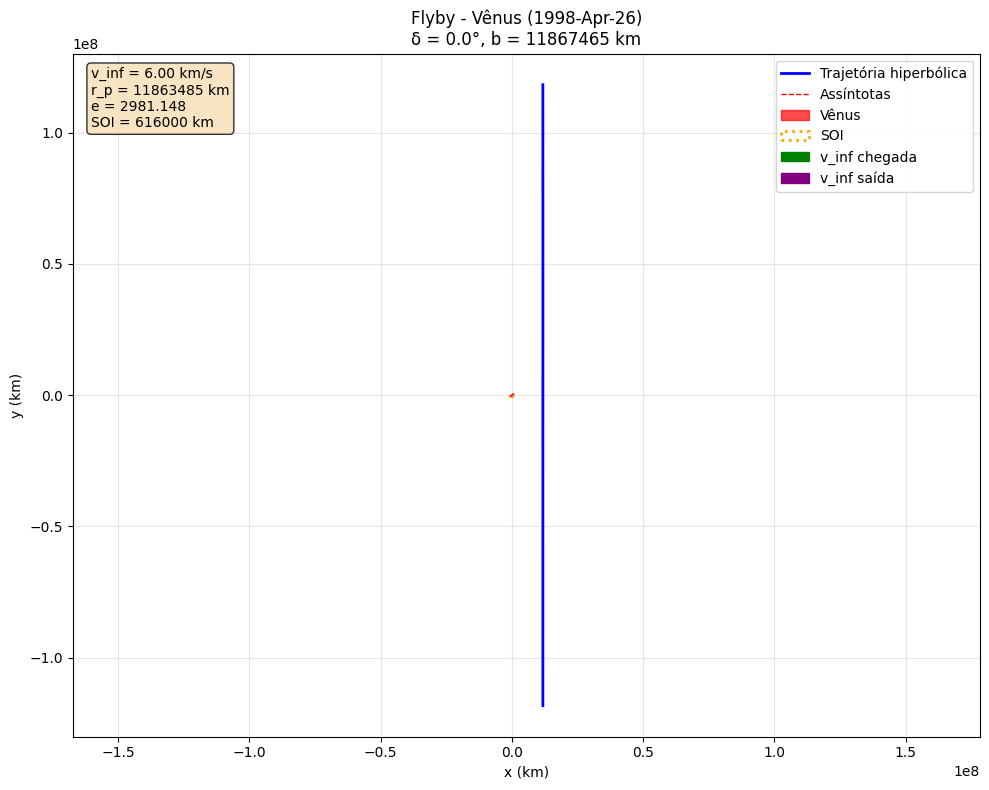


FLYBY 2: VÊNUS (24 de Junho de 1999)
Parâmetros do Flyby em 1999-Jun-24:
Planeta: Vênus
Raio planeta-Sol: 1.08e+08 km
Velocidade de aproximação (v_inf): 12.57 km/s
Ângulo de deflexão: 1.39°
Parâmetro de impacto (b): 169716.16 km
Distância do periapsis (r_p): 167674.22 km
Excentricidade: 82.6185


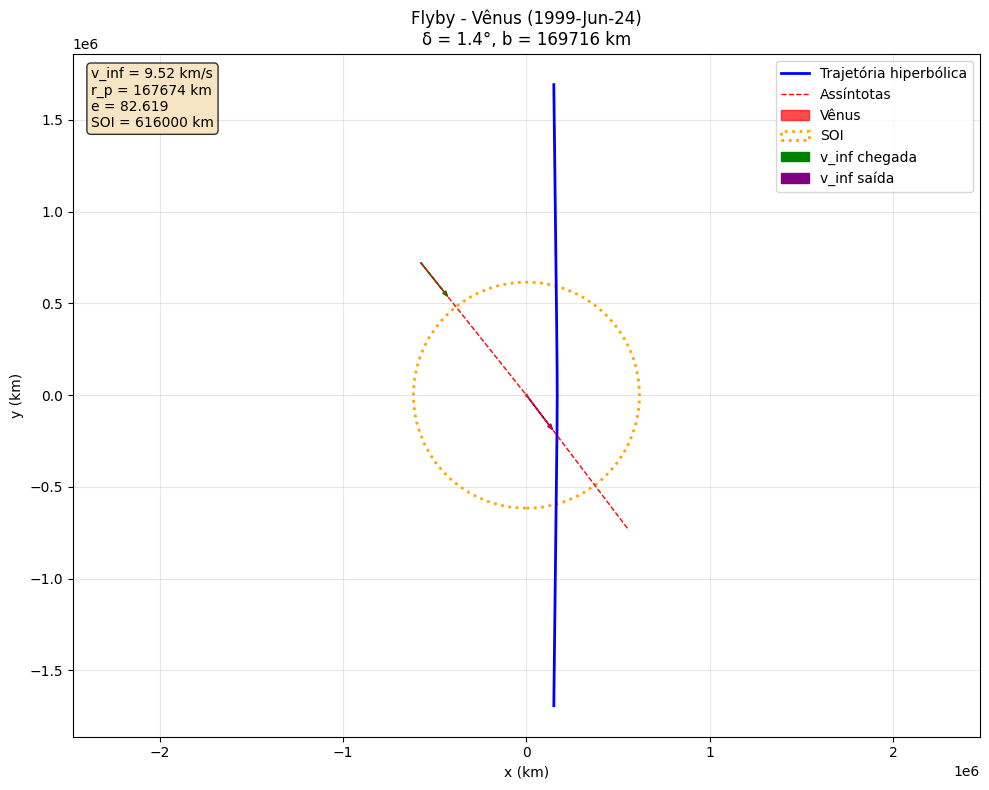


FLYBY 3: TERRA (18 de Agosto de 1999)
Parâmetros do Flyby em 1999-Aug-18:
Planeta: Terra
Raio planeta-Sol: 1.51e+08 km
Velocidade de aproximação (v_inf): 18.20 km/s
Ângulo de deflexão: 92.79°
Parâmetro de impacto (b): 1146.17 km
Distância do periapsis (r_p): 458.48 km
Excentricidade: 1.3810


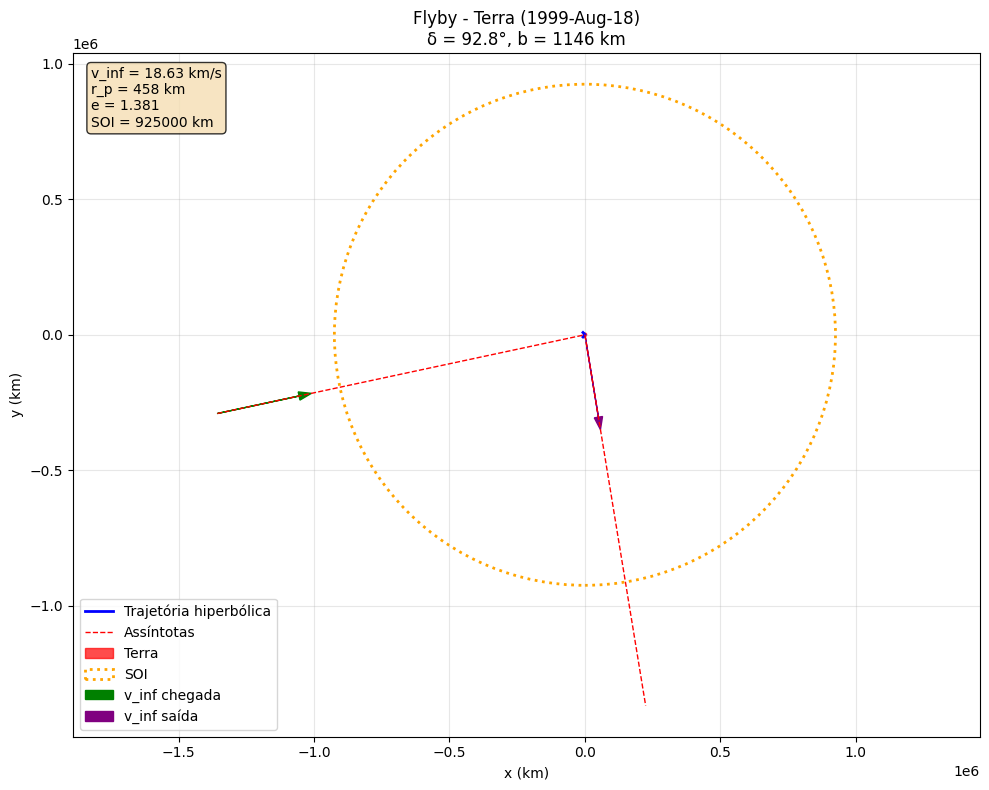


FLYBY 4: JÚPITER (30 de Dezembro de 2000)
Parâmetros do Flyby em 2000-Dec-30:
Planeta: Júpiter
Raio planeta-Sol: 7.55e+08 km
Velocidade de aproximação (v_inf): 6.37 km/s
Ângulo de deflexão: 36.17°
Parâmetro de impacto (b): 9563164.40 km
Distância do periapsis (r_p): 6937239.21 km
Excentricidade: 3.2214


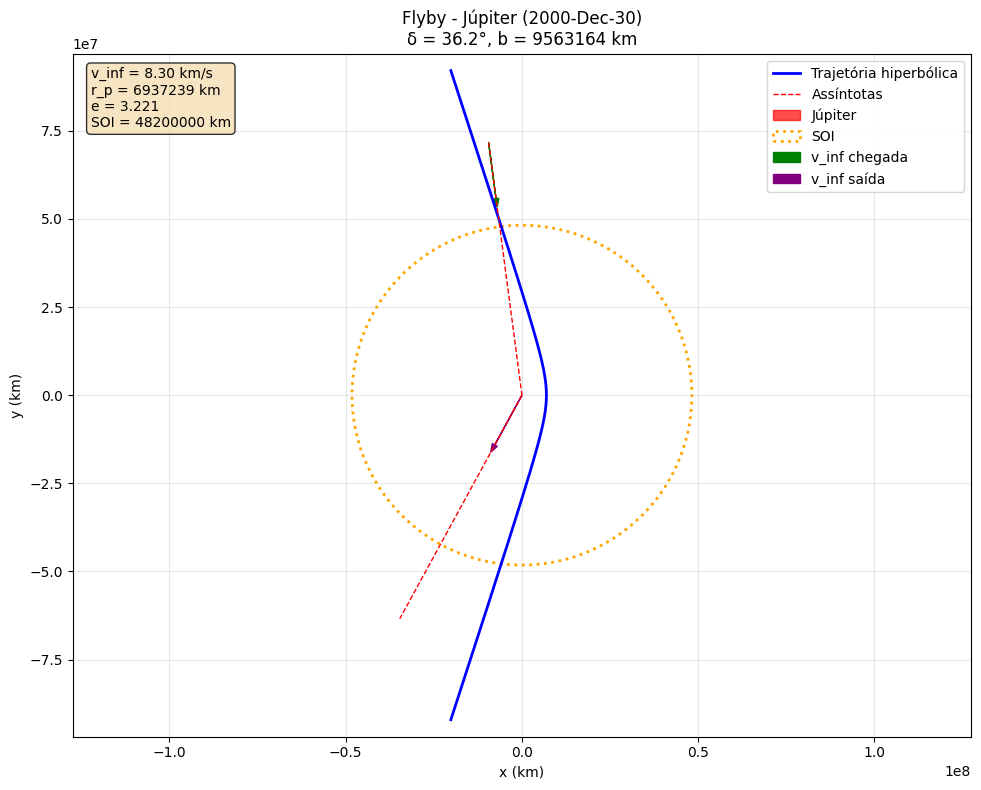


RESUMO DE TODOS OS FLYBYS

Vênus 1:
  v_inf = 9.03 km/s
  Ângulo de deflexão = 0.04°
  Parâmetro de impacto = 11867464.81 km
  Distância do periapsis = 11863484.64 km

Vênus 2:
  v_inf = 12.57 km/s
  Ângulo de deflexão = 1.39°
  Parâmetro de impacto = 169716.16 km
  Distância do periapsis = 167674.22 km

Terra:
  v_inf = 18.20 km/s
  Ângulo de deflexão = 92.79°
  Parâmetro de impacto = 1146.17 km
  Distância do periapsis = 458.48 km

Júpiter:
  v_inf = 6.37 km/s
  Ângulo de deflexão = 36.17°
  Parâmetro de impacto = 9563164.40 km
  Distância do periapsis = 6937239.21 km


In [153]:
# 1. Primeiro flyby de Vênus - 26 de Abril de 1998
print("\n" + "="*80)
print("FLYBY 1: VÊNUS (26 de Abril de 1998)")
print("="*80)
flyby_venus1 = flyby(orbita1, orbita2, planetas['Venus'], '1998-Apr-26', plot=True)

# 2. Segundo flyby de Vênus - 24 de Junho de 1999
print("\n" + "="*80)
print("FLYBY 2: VÊNUS (24 de Junho de 1999)")
print("="*80)
flyby_venus2 = flyby(orbita3, orbita4, planetas['Venus'], '1999-Jun-24', plot=True)

# 3. Flyby da Terra - 18 de Agosto de 1999
print("\n" + "="*80)
print("FLYBY 3: TERRA (18 de Agosto de 1999)")
print("="*80)
flyby_terra = flyby(orbita4, orbita5, planetas['Terra'], '1999-Aug-18', plot=True)

# 4. Flyby de Júpiter - 30 de Dezembro de 2000
print("\n" + "="*80)
print("FLYBY 4: JÚPITER (30 de Dezembro de 2000)")
print("="*80)
flyby_jupiter = flyby(orbita5, orbita6, planetas['Jupiter'], '2000-Dec-30', plot=True)

# Resumo de todos os flybys
print("\n" + "="*80)
print("RESUMO DE TODOS OS FLYBYS")
print("="*80)

flybys = {
    'Vênus 1': flyby_venus1,
    'Vênus 2': flyby_venus2,
    'Terra': flyby_terra,
    'Júpiter': flyby_jupiter
}

for nome, dados in flybys.items():
    print(f"\n{nome}:")
    print(f"  v_inf = {dados['v_inf']:.2f} km/s")
    print(f"  Ângulo de deflexão = {np.degrees(dados['delta_angle']):.2f}°")
    print(f"  Parâmetro de impacto = {dados['impact_parameter']:.2f} km")
    print(f"  Distância do periapsis = {dados['periapsis_distance']:.2f} km")